In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, PowerTransformer

In [2]:
df = pd.read_csv(os.path.join("data", "processed", "all_data.csv"))
df.set_index("commune_id", inplace=True)
df.head()

,name,residents,population_change,population_density,foreign_nationals_percent,age_0_19,age_20_64,age_65_over,marriage_rate,divorce_rate,...,total_tax_income,per_capita_tax_income,unemployed,unemployment_rate,crime_rate_stgb,typology,n_machines,e_cntr,n_cntr,z_min
commune_id,,,,,,,,,,,,,,,,,,,,,
1.0,Aeugst am Albis,1982.0,8.662281,250.568900,13.874874,19.677094,62.764884,17.558022,4.588325,2.039256,...,101.3324,51255.639858,18228.0,2.1275,32.699244,23,0.0,2679300,1235700,533
2.0,Affoltern am Albis,12229.0,10.260572,1154.768650,28.628670,20.508627,61.329626,18.161747,4.676923,2.133333,...,381.2711,32039.588235,18228.0,2.1275,32.699244,11,3.0,2676800,1236800,440
3.0,Bonstetten,5548.0,7.540221,746.702557,16.005768,23.666186,60.310022,16.023792,4.159132,1.265823,...,214.2104,39413.137075,18228.0,2.1275,32.699244,22,1.0,2677800,1241000,502
4.0,Hausen am Albis,3701.0,10.148810,272.132353,15.617401,21.804918,60.686301,17.508781,4.887984,2.172437,...,138.4407,38768.048166,18228.0,2.1275,32.699244,22,0.0,2682900,1233100,524
5.0,Hedingen,3734.0,9.501466,571.822358,15.854312,21.772898,61.756829,16.470273,3.500269,1.884760,...,151.8671,41189.883374,18228.0,2.1275,32.699244,11,2.0,2676400,1239000,475


## Geographic features

### Distance from SBB ticket vending machine

In [3]:
# SBB ticket vending machines
df_tvm = pd.read_csv(os.path.join("data", "processed", "billetautomat_w_comm.csv"))
df_tvm.head()

,Unnamed: 0,ch_n,ch_e,station_name,lat,lon,commune_id,name,canton
0,0,1191280.192,2759449.251,Chur,46.853537,9.529628,3901.0,Chur,GR
1,1,1191279.711,2759450.545,Chur,46.853532,9.529645,3901.0,Chur,GR
2,2,1208007.866,2758940.604,Maienfeld,47.004074,9.528805,3953.0,Maienfeld,GR
3,3,1203981.303,2761001.952,Landquart,46.967371,9.554472,3955.0,Landquart,GR
4,4,1191281.005,2759450.130,Chur,46.853544,9.529640,3901.0,Chur,GR


In [4]:
def tvm_dist(e, n):
    # distance from coordinates (e, n) to nearest ticket vending machine
    return (np.sqrt((e - df_tvm["ch_e"])**2 + (n - df_tvm["ch_n"])**2)).min()

In [5]:
# calculcate tvm distance for all communes
df["tvm_distance"] = df.apply(lambda row: tvm_dist(row["e_cntr"], row["n_cntr"]), axis=1)

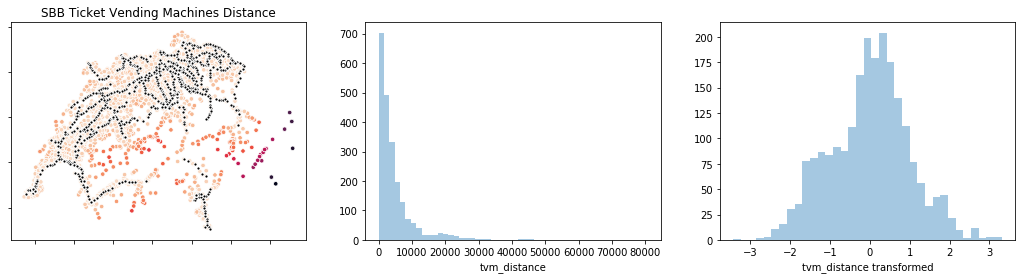

In [6]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize = (18, 4))
sns.scatterplot(data=df, x="e_cntr", y="n_cntr", hue="tvm_distance", palette="rocket_r", s=20, ax=ax0)
sns.scatterplot(data=df_tvm, x="ch_e", y="ch_n", marker=".", color="black", ax=ax0)
ax0.legend_.remove()
ax0.set(xticklabels=[])
ax0.set_xlabel("")
ax0.set(yticklabels=[])
ax0.set_ylabel("")
ax0.set_title("SBB Ticket Vending Machines Distance")
sns.distplot(df["tvm_distance"], kde=False, ax=ax1)
pt = PowerTransformer()
transformed_tvm_dist = pt.fit_transform(df["tvm_distance"].values.reshape(-1, 1))
sns.distplot(transformed_tvm_dist, kde=False, ax=ax2)
ax2.set_xlabel("tvm_distance transformed")
plt.show()

In [7]:
df["transformed_tvm_dist"] = transformed_tvm_dist
df[["tvm_distance","transformed_tvm_dist", "e_cntr", "n_cntr", "po_value"]].corr()

,tvm_distance,transformed_tvm_dist,e_cntr,n_cntr,po_value
tvm_distance,1.000000,0.776781,0.218859,-0.248390,0.202198
transformed_tvm_dist,0.776781,1.000000,0.049621,-0.251283,0.240170
e_cntr,0.218859,0.049621,1.000000,0.330853,0.467519
n_cntr,-0.248390,-0.251283,0.330853,1.000000,0.277844
po_value,0.202198,0.240170,0.467519,0.277844,1.000000


In [8]:
df.drop(columns="transformed_tvm_dist", inplace=True)

### Distance from airport

In [9]:
# must be int64, int32 will overflow
# ZRH, GVA, BSL, MXP airport coordinates (manually derived)
airports = np.array([(2684745, 1256137), (2497416, 1121168), (2607041, 1272133), (2700520, 1054540)], dtype=np.int64) 

def airport_dist(e, n):
    # distance from coordinates (e, n) to nearest airport
    return (np.sqrt((e - airports[:,0])**2 + (n - airports[:,1])**2)).min()

In [10]:
# calculcate airport distance for all communes
df["airport_distance"] = df.apply(lambda row: airport_dist(row["e_cntr"], row["n_cntr"]), axis=1)

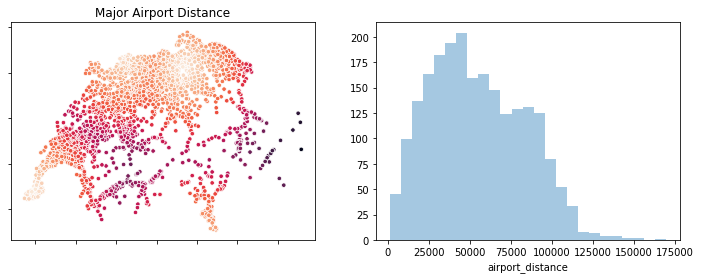

In [11]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize = (12, 4))
sns.scatterplot(data=df, x="e_cntr", y="n_cntr", hue="airport_distance", palette="rocket_r", s=20, ax=ax0)
ax0.legend_.remove()
ax0.set(xticklabels=[])
ax0.set_xlabel("")
ax0.set(yticklabels=[])
ax0.set_ylabel("")
ax0.set_title("Major Airport Distance")
sns.distplot(df["airport_distance"], kde=False, ax=ax1)
plt.show()

In [12]:
df[["airport_distance", "e_cntr", "n_cntr", "po_value"]].corr()

,airport_distance,e_cntr,n_cntr,po_value
airport_distance,1.000000,0.034298,-0.472547,0.063903
e_cntr,0.034298,1.000000,0.330853,0.467519
n_cntr,-0.472547,0.330853,1.000000,0.277844
po_value,0.063903,0.467519,0.277844,1.000000


### Distance from Geneva

In [13]:
# UNO 2499842, 1120293
geneva = np.array([2499842, 1120293], dtype=np.int64)
def geneva_dist(e, n):
    # distance from coordinates (e, n) to Geneva, Palais des Nations
    return (np.sqrt((e - geneva[0])**2 + (n - geneva[1])**2))

# calculcate airport distance for all communes
df["geneva_distance"] = df.apply(lambda row: geneva_dist(row["e_cntr"], row["n_cntr"]), axis=1)

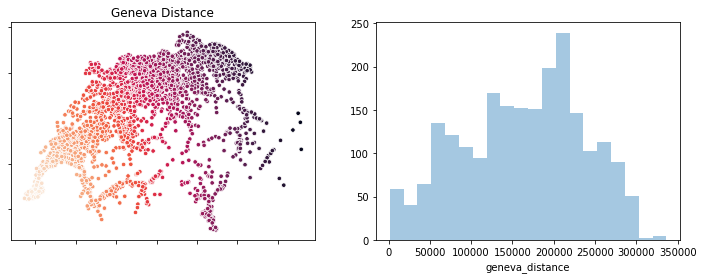

In [14]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize = (12, 4))
sns.scatterplot(data=df, x="e_cntr", y="n_cntr", hue="geneva_distance", palette="rocket_r", s=20, ax=ax0)
ax0.legend_.remove()
ax0.set(xticklabels=[])
ax0.set_xlabel("")
ax0.set(yticklabels=[])
ax0.set_ylabel("")
ax0.set_title("Geneva Distance")
sns.distplot(df["geneva_distance"], kde=False, ax=ax1)
plt.show()

In [15]:
df[["geneva_distance", "e_cntr", "n_cntr", "po_value"]].corr()

,geneva_distance,e_cntr,n_cntr,po_value
geneva_distance,1.000000,0.962304,0.556679,0.460372
e_cntr,0.962304,1.000000,0.330853,0.467519
n_cntr,0.556679,0.330853,1.000000,0.277844
po_value,0.460372,0.467519,0.277844,1.000000
